# S04 - (s, S) Inventory Simulation

---
This notebook provides an example of the use of `DataFrame` to calculate the inventory performance based on estimated demand. The objective for you is to *understand* what each cell of codes does. Developing it by yourself requires time and experience but if you generally understand the process and code, that suffices.

---
## Inventory Simulation using pandas
In this exercise, you will use the pandas library to simulate different inventory policies for a planning horizon of one year.

### Step 1: Reading Data
Import the pandas library under the alias `pd`. Import the csv file `DemandSimulation.csv` into a `DataFrame`, and select the first column named `'Week'` as the index of the `DataFrame`.

**$\color{blue}{\textbf{Hint:}}$** you can define the index column of the `DataFrame` using the `index_col` parameter of the `.read_csv()` function. Check [this page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) for more information.

In [1]:
import pandas as pd

# This is a csv file which is online. You can also download it by going at the link.
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S04_Data_Structures_2/data/DemandScenarios.csv'
demand_scenario_df = pd.read_csv(url, index_col='Week')
demand_scenario_df.shape

(52, 3)

Now display the first 10 rows of your `DataFrame`. You can see that the file contains first column as indexes (weeks) and each of the subsequent column contains a list of estimated demands for each scenario.

In [2]:
demand_scenario_df.head(10)

,Scenario1,Scenario2,Scenario3
Week,,,
1,18,21,17
2,16,16,15
3,13,13,11
4,17,17,16
5,11,11,10
6,20,23,18
7,15,17,13
8,20,20,17
9,15,16,13


---
### Step 2: Simulation and Output a `DataFrame` Object
Now, we will simulate different inventory policies based on the inventory model $(s,S)$ for a specific demand scenario and analyze/visualize the performance based on a given policy based on that specific demand scenario.

> The inventory model min-max or $(s,S)$ is one of the most commonly used inventory system in practice. Here are the details of the inventory system. In this one, the min/max is applied to periodic system where the inventory is checked periodically every period (e.g., once a day or once a week) (Note that this system can also be applied in a real-time ordering system but in practice orders would be placed periodically).
> *   There are two parameters that must be determined to control the inventory replenishment: $s$ which represents the minimum inventory level (or reorder point), and $S$ which represents the desired target inventory level. 
> *   **At the beginning of each period**, this system constantly checks the inventory position (current inventory + in-transit inventory) for the product. 
> *   If the inventory position drops below the min level $s$, the systems create an order refill inventory to raise the inventory position to the max level $S$. The order quantity $Q$ is then $Q = S - \mathit{inventory\; position}$ (recall that inventory position = current + in-transit). This order quantity arrives after the lead time. 

In this exercise you will create a function which simulates your inventory performance for a given $(s,S)$ policy. This function should return a `DataFrame` object containing inventory levels (at the beginning and at the end of each period), orders to place and orders to receive at each time period (week) of the simulated planning horizon. Here are some instructions.

The function will require the following input parameters:
* The `Series` of one scenario from the DataFrame, which contains the simulated demand data for that specific scenario
* (number) initial inventory level at the begining of the planning horizon
* (number) lead time in weeks
* (number) $s$ value, i.e., minimum inventory level 
* (number) $S$ value, i.e., maximun inventory level 

The output of your function should be a `DataFrame` with 52 rows (52 weeks) and  four columns as follows:
* `'Start_Inv'`: inventory level at the beginning of each week
* `'Receipt'`: units received at each week
* `'Ending_Inv'`: inventory level at the end of each week 
* `'Order'`: order quantity in units

Note that the inventory level can be negative if you have a backlog (demand is more than available quantity). In that case, the negative value is carried forward to a subsequent period to be satistied. 

**$\color{blue}{\textbf{Hints:}}$** 
* *We use the method `df.index` to access the list of indexes of the `DataFrame` you created in the previous exercises.*
* *We initialize the first row of the `'Start_Inv'` column as the initial inventory level given as input. You can also initialize the `'Receipt'` entries as $0$ from the beginning of the planning horizon until the time period equals to the lead time.*
* *We then use a `for` loop to iterate over the planning horizon and compute the corresponding values for `'Start_Inv'`, `'Receipt'`, `'Ending_Inv'`, `'Order'`.*

Here we provide the remaining inputs required for the simulation

In [3]:
# Parameters for the model
init_inv = 27  # initial inventory level
lead_time = 2  # leadtime 

# Parameters to set (s,S) policy
s_min = 25  # this is the small s
s_max = 70  # this is the big s

demand_series = demand_scenario_df['Scenario1']  # we are taking the first scenario here
demand_series.head()

Week
1    18
2    16
3    13
4    17
5    11
Name: Scenario1, dtype: int64

We can create an empty DataFrame to store the results

In [4]:
# creating an (empty) dataframe to keep the results
column_names = ['Start_Inv', 'Receipt', 'Demand', 'Ending_Inv', 'Order']
n_weeks = len(demand_series.index)
inv_dataframe = pd.DataFrame(index = range(1, n_weeks + 1), columns=column_names)
inv_dataframe.index.name ='Week'  # give the index name to the output dataframe
inv_dataframe.head()

,Start_Inv,Receipt,Demand,Ending_Inv,Order
Week,,,,,
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN


You can first initialize the initial inventory and also set the order receipts of the period < lead time to be zero (if we order now, the earliest arrival will be after the leadtime). You can also set the demand column too.

In [5]:
# initializing current inventory levels and order receipt up to t=lead_time
inv_dataframe.loc[1, 'Start_Inv'] = init_inv 
for t in range(1, lead_time + 1): 
    inv_dataframe.loc[t,'Receipt'] = 0

# add the values to demand column from the series
inv_dataframe['Demand'] = demand_series
inv_dataframe.head() # review the result

,Start_Inv,Receipt,Demand,Ending_Inv,Order
Week,,,,,
1,27,0,18,NaN,NaN
2,NaN,0,16,NaN,NaN
3,NaN,NaN,13,NaN,NaN
4,NaN,NaN,17,NaN,NaN
5,NaN,NaN,11,NaN,NaN


Now at each iteration, we need to calculate the ending inventory at $Inv_t$ from the ending inventory from the previous period $Inv_{t-1}$, quantity received and demand using the following flow conservation.

$Inv_{t}$ = $Inv_{t-1} + Receipt_{t} - Demand_{t}$

Note that the ending inventory at period $t$ is the starting inventory at period $t+1$. Again, inventory can be negative if you have a backlog.

**Note:** please examine the following code to understand the process. It is fine if you cannot develop it from scratch. The objective of this is to show how the process/code looks like. We try to put the comments to be as explicit as possible.

In [6]:
# assign values to the entries of the dataframe
for t in range(1, n_weeks + 1):
    # compute inventory levels at the begining and end of each period
    if t > 1: 
        # set Start_Inv at t equal to Ending_Inv at t-1
        # skip t=1 since we already have Start_Inv at t=1
        inv_dataframe.loc[t, 'Start_Inv'] = inv_dataframe.loc[t - 1, 'Ending_Inv']
    
    # compute inventory flow for Ending_Inv of the current period
    inv_dataframe.loc[t, 'Ending_Inv'] = (inv_dataframe.loc[t, 'Start_Inv']
                                          + inv_dataframe.loc[t,'Receipt']
                                          - inv_dataframe.loc[t, 'Demand'])
        
    # compute orders and receipts for period t
    # compute intransit (outstanding) inventory
    # note: pandas includes the end point of a slice (here, t-1)
    intransit_quantity = sum(inv_dataframe.loc[max(0,t-lead_time+1):t-1, 'Order']) 
    # compute inventory position
    inv_position = inv_dataframe.loc[t, 'Ending_Inv'] + intransit_quantity
    if  inv_position < s_min:  # in this case an order must be placed
        # create an order Q = s_max - current inventory position
        inv_dataframe.loc[t, 'Order'] = s_max - inv_position 
        # check if we reach the end of dataframe, if not, we add the order receipt after the leadtime 
        if t + lead_time <= max(inv_dataframe.index):    
            inv_dataframe.loc[t+lead_time, 'Receipt'] = inv_dataframe.loc[t, 'Order']
    else:  # no order is placed if 'Ending_Inv' >= s_min
        inv_dataframe.loc[t, 'Order'] = 0   
        if t + lead_time <= max(inv_dataframe.index):
            inv_dataframe.loc[t+lead_time, 'Receipt'] = 0  # no orders receipt in t+leadtime periods

Now you can examine the results.

In [7]:
print("(s,S) = (",s_min,",",s_max,")")
inv_dataframe

(s,S) = ( 25 , 70 )


,Start_Inv,Receipt,Demand,Ending_Inv,Order
Week,,,,,
1,27,0,18,9,61
2,9,0,16,-7,0
3,-7,61,13,41,0
4,41,0,17,24,46
5,24,0,11,13,0
6,13,46,20,39,0
7,39,0,15,24,46
8,24,0,20,4,0
9,4,46,15,35,0


---
### Step 3: Plotting Data

We can also visualize the data directly from the dataframe by taking a column.

<AxesSubplot:xlabel='Week'>

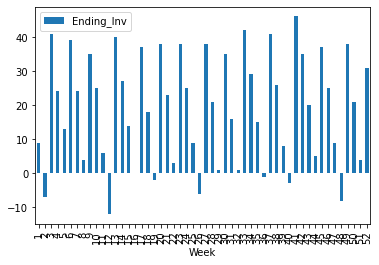

In [8]:
inv_dataframe[["Ending_Inv"]].plot(kind='bar')   # plot inv levels

This can even be done for more than one column. 

<AxesSubplot:xlabel='Week'>

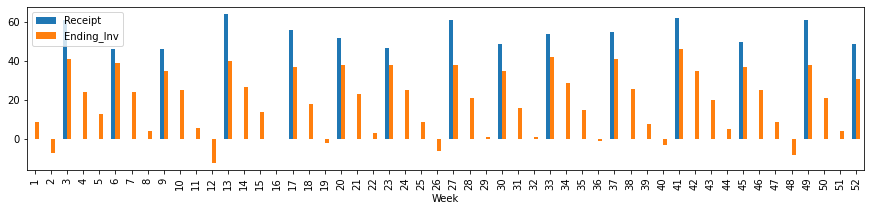

In [9]:
inv_dataframe[["Receipt", "Ending_Inv"]].plot(kind='bar', figsize=(15,3))   # plot inv and receipts and resize the plot

It is also possible to do a histogram.

<AxesSubplot:ylabel='Frequency'>

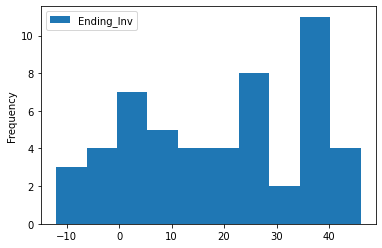

In [14]:
inv_dataframe = inv_dataframe.astype(float)  # we need to apply this otherwise an error occurs since the type is 'object'
inv_dataframe[['Ending_Inv']].plot(kind='hist') 

### Step 4: Summarizing the Results 
We can also use the DataFrame methods to summarize the results. 
See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.lt.html for more details.

In [19]:
backlog_num = inv_dataframe['Ending_Inv'].lt(0).sum()
backlog_total_units = inv_dataframe['Ending_Inv'].loc[inv_dataframe['Ending_Inv'] < 0].sum() #this number is negative
demand_total = inv_dataframe['Demand'].sum()
order_total = inv_dataframe['Order'].sum()
order_num = inv_dataframe['Order'].gt(0).sum()
inv_total_units = inv_dataframe['Ending_Inv'].loc[inv_dataframe['Ending_Inv'] > 0].sum()

print("Performance of (s,S) = (",s_min,",",s_max,") under demand scenario:",demand_series.name)
print("Total number of orders =",order_num,", Average order quantity =","{:.2f}".format(order_total / order_num))
print("Average inventory per week =", "{:.2f}".format(inv_total_units / n_weeks))
print("Average number of backlogged units per week =", "{:.2f}".format(abs(backlog_total_units / n_weeks)))
print("Number of backlog incidents =", backlog_num)
print("Service Level =", "{:.2f}".format(( 1 - backlog_num / n_weeks) * 100),"%") # % of times the demand is completely fulfilled
print("Fill rate =", "{:.2f}".format(((demand_total + backlog_total_units) / demand_total) * 100),"%")  # % of quantity fulfilled on-time

Performance of (s,S) = ( 25 , 70 ) under demand scenario: Scenario1
Total number of orders = 15 , Average order quantity = 54.20
Average inventory per week = 19.92
Average number of backlogged units per week = 0.75
Number of backlog incidents = 7
Service Level = 86.54 %
Fill rate = 95.18 %


### Playing with the Code
You can now repeat the process above with a different demand scenario (e.g., choosing the 'Scenario2' or 'Scenario3' and vary the inventory control parameters `s_min` and `s_max` and explore the results.